<a href="https://colab.research.google.com/github/rdemarqui/llm_complaint_management/blob/main/02.%20LLM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM at Work: Decoding Customer Feedback

This study aims to explore these technological advancements, specifically using the advanced LLM tool Mistral 7B, to analyze a vast collection of complaints gathered from the website [reclameaqui.com.br](reclameaqui.com.br). Through this analysis, we intend to demonstrate the potential and effectiveness of LLMs in interpreting and handling large-scale user feedback.

For more information, please visit my github page: https://github.com/rdemarqui/llm_complaint_management

## Complaint Dataset

### Load

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
# Loading data
data_url = 'https://raw.githubusercontent.com/rdemarqui/llm_complaint_management/main/datasets/full_dataset_claro.xlsx'
data = pd.read_excel(data_url, usecols=['problem', 'description'])
print(data.shape)

(7000, 2)


### Clean

In [36]:
# Remove extra space and uncase all words
data['description'] = data['description'].astype(str)
data['description'] = data['description'].str.replace(r'\s{2,}', ' ', regex=True)
data['description'] = data['description'].str.lower()

In [37]:
# Modify mask made by reclame aqui
def remove_mask(text):
  return text.replace("[editado pelo reclame aqui]", "[mask]")

data['description'] = data['description'].apply(remove_mask)

### Stratify

As this work is intended for study purposes, we will only work with a fraction of the data. With the infrastructure provided by the Colab free tier, I noticed that on average, Mistral 7B analyzes about 2,000 complaints per hour. Therefore, we will use this number of cases in our analysis. To do this, we will perform a stratified sample.

In [38]:
# Get stratified data
df, _ = train_test_split(data, train_size=2002, stratify=data['problem'], random_state=42)
df.reset_index(inplace=True, drop=True)
df.shape

(2002, 2)

In [39]:
df.head()

,problem,description
0,Problemas com o chip,boa noite!!!fiz uma portabilidade da vivo para...
1,Problemas com o chip,perdi meu celular e ao tentar solicitar um nov...
2,Corte indevido da linha,é a segunda reclamação que estou fazendo e a c...
3,Cancelamento,solicitei portabilidade da vivo para a claro p...
4,Problemas com o chip,"contratei este prezao celular, paguei 20,00 re..."


### Analysis

In [40]:
# Show each problem category
df['problem'].value_counts()

Problemas com o chip                       143
Corte indevido da linha                    143
Cancelamento                               143
Problema com recarga                       143
Planos e tarifas                           143
Mudança de plano                           143
Promoções                                  143
Qualidade da internet                      143
Consumo de crédito                         143
Instabilidade do sinal                     143
Demora na execução                         143
Cobrança indevida                          143
Portabilidade                              143
Mau atendimento do prestador de serviço    143
Name: problem, dtype: int64

In [41]:
# Show statistics of words
df['word_count'] = df['description'].str.split().str.len()
df['text_len'] = df['description'].str.len()
df['word_count'].describe()

count    2002.00000
mean      110.19031
std        85.71323
min         1.00000
25%        53.00000
50%        86.00000
75%       143.00000
max       747.00000
Name: word_count, dtype: float64

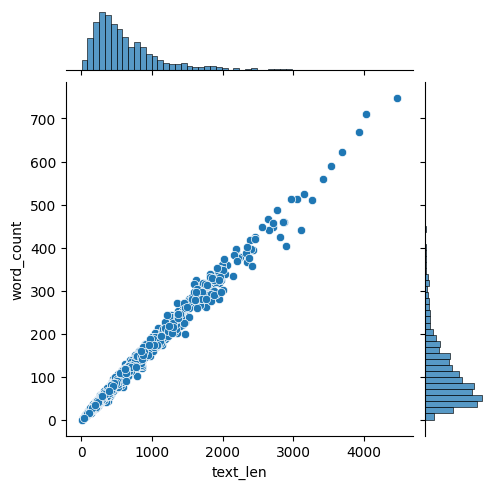

In [42]:
# Check correlation between word count and text lenght
sns.jointplot(data=df, x="text_len", y="word_count", height=5);

In [43]:
# Check word median per category
df.groupby('problem')['word_count'].median()

problem
Cancelamento                                95.0
Cobrança indevida                          113.0
Consumo de crédito                          83.0
Corte indevido da linha                    106.0
Demora na execução                          82.0
Instabilidade do sinal                      67.0
Mau atendimento do prestador de serviço     92.0
Mudança de plano                            96.0
Planos e tarifas                            98.0
Portabilidade                               99.0
Problema com recarga                        73.0
Problemas com o chip                        90.0
Promoções                                   63.0
Qualidade da internet                       74.0
Name: word_count, dtype: float64

## Text Classification

### Loading Model

There are several 7B models available as open source, such as Mistral, Falcon, Zephyr, and Openchat. In this study we will use Mistral, but other models can also be tested, just paying attention to adapting the instruction structure.

In [12]:
import time
from datetime import timedelta
from google.colab import files
from IPython.display import clear_output

In [13]:
# Latest HF transformers version for Mistral-like models
!pip install git+https://github.com/huggingface/transformers.git

# GPTQ Dependencies
!pip install optimum
!pip3 install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

clear_output()

In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

We will use the pre-trained Mistral 7B model, quantized by the user TheBloke and available at https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GPTQ.

For more information on quantization, there is an excellent article written by Maxime Labonne:
* https://towardsdatascience.com/introduction-to-weight-quantization-2494701b9c0c

In [15]:
# Load LLM and Tokenizer
model_id = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)
clear_output()

In [16]:
# Create a pipeline
generator = pipeline(model=model,
                tokenizer=tokenizer,
                task='text-generation',
                max_new_tokens=50,
                temperature=0.20,
                do_sample=True
                )
clear_output()

### Prompt Engineering

Prompt Guide:
* https://www.promptingguide.ai/models/mistral-7b

In [ ]:
few_shot = """
<s>
[INST]
Reclamação: A cobertura é ruim e minha fatura está incorreta!
Tarefa: Classifique a reclamação acima.
[/INST] sinal/conexão de rede; cobrança indevida
[INST]
Reclamação: Recebo muitas mensagens de propaganda.
Tarefa: Classifique a reclamação acima.
[/INST] spam
</s>
"""

In [83]:
# This is the footprint of your prompt. This will be replicated in all prompts
prompt_footprint = """[INST]
Reclamação: {user_complain}
Tarefa: Classifique a reclamação acima baseado em uma ou mais categorias abaixo.
sinal/conexão de rede; cobrança indevida; consumo saldo/crédito; plano/benefício; cancelar linha/plano; recuperar número/linha; chip/sim card; spam; portabilidade; recarga/pagamento; atendimento ineficiente

Atenção use apenas as categorias, não explique!
[/INST]"""

In [84]:
# Build the prompt
prompt = few_shot + prompt_footprint
print(prompt)


<s>
[INST]
Reclamação: A cobertura é ruim. Minha fatura está incorreta!
Tarefa: Classifique a reclamação acima.
[/INST] sinal/conexão de rede; cobrança indevida
[INST]
Reclamação: Não consigo falar com a atendente.
Tarefa: Classifique a reclamação acima.
[/INST] atendimento ineficiente
</s>
[INST]
Reclamação: {user_complain}
Tarefa: Classifique a reclamação acima baseado em uma ou mais categorias abaixo.
sinal/conexão de rede; cobrança indevida; consumo saldo/crédito; plano/benefício; cancelar linha/plano; recuperar número/linha; chip/sim card; spam; portabilidade; recarga/pagamento; atendimento ineficiente

Atenção use apenas as categorias, não explique!
[/INST]


In [85]:
def llm_analysis(complain):
  response = generator(prompt.format(user_complain=complain))
  llm_classification = response[0]['generated_text'].split('[/INST]')[-1][1:].replace('.', '').split('\n')[0]

  return llm_classification

In [86]:
# Example
example ="""
em novembro de 2022 recebi uma propaganda com oferta da claro, anunciando um plano para celular conforme mostrado no print anexado. segundo o anúncio, caso eu colocasse o pagamento em débito automático, o plano que era no valor de r$49,90 ficaria por r$34,90.eu assinei o plano e coloquei em débito automático na minha conta do banco do brasil. no mês de dezembro/2022 o valor cobrado no débito automático foi de r$35,70. em janeiro e fevereiro/2023 o valor cobrado subiu para r$44,90.gostaria que a claro cumprisse com o que foi anunciado, cobrando r$34,90 e ressarcisse os valores que foram cobrados a mais nos 2 meses citados. seguem os comprovantes do anúncio, da confirmação da contratação e de um dos meses que o valor foi cobrado indevidamente, pois aqui no site não consigo anexar mais do que 3 arquivos. porém tenho o print do mês de fevereiro também.
""".lower()

analysis = llm_analysis(example)
print(analysis)

cobrança indevida; plano/benefício; atendimento ineficiente


### Classification

**Note:** Depending on the amount of data, the classification process can take a few hours. Using the model described above and utilizing the free tier infrastructure of Colab, I noticed that Mistral takes about an hour to classify 2,000 cases.

Colab tends to disconnect due to inactivity. To prevent this, open your browser's inspector, go to the console tab, paste the code below, and press enter.

`function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)`

In [88]:
def iterate_over_interval(df, column, limit_char, start_row, end_row):
  for index in range(start_row, end_row + 1):
    complaint_content = str(df.loc[index, column]).lower()

    # Limit text lengh
    if len(complaint_content) > limit_char: complaint_content = complaint_content[:limit_char]+'\n'

    #print(prompt.format(user_complain=complaint_content))  # check prompt

    # Text analysis
    analysis = llm_analysis(complaint_content)
    df.at[index, 'llm_class'] = analysis

  # Save final result
  file_save = 'analise_reclamacao_' + str(start_row) + '_' + str(end_row) + '.xlsx'
  df.to_excel(file_save, index=False)

**Note:** As can be seen in the analysis above, the complaints have a median of 86 words and a text length with a median of 500 characters. Few texts exceed 2000 characters, for this reason, we will limit the text size to be passed to the model to this value.

In [ ]:
start_time = time.time()

iterate_over_interval(df=df, column="description",
                      limit_char=2000,
                      start_row=0, end_row=100)

end_time = time.time()
delta_time = str(timedelta(seconds=end_time - start_time))
print(f"Execution: {delta_time}")

## Results

In [81]:
df

,problem,description,word_count,text_len,llm_class
0,Problemas com o chip,boa noite!!!fiz uma portabilidade da vivo para...,203,1155,chip/sim card; cobrança indevida; atendimento ...
1,Problemas com o chip,perdi meu celular e ao tentar solicitar um nov...,66,367,cancelar linha/plano; atendimento ineficiente
2,Corte indevido da linha,é a segunda reclamação que estou fazendo e a c...,32,185,sinal/conexão de rede; atendimento ineficiente
3,Cancelamento,solicitei portabilidade da vivo para a claro p...,136,752,sinal/conexão de rede; cobrança indevida; plan...
4,Problemas com o chip,"contratei este prezao celular, paguei 20,00 re...",13,80,chip/sim card; cancelar linha/plano; cobrança ...
...,...,...,...,...,...
1997,Problemas com o chip,"comprei um chip da claro no dia 13/07/22, a ve...",108,631,NaN
1998,Mudança de plano,em dezembro de 2022 a claro me ligou e me ofer...,173,961,NaN
1999,Cancelamento,no dia 27/05/23 a claro me ofereceu um upgrade...,368,2210,NaN
2000,Qualidade da internet,"perdi meu celular, comprei novo chip fiz a tro...",118,616,NaN


---